<a href="https://colab.research.google.com/github/newmancia/CataloguesUADEC/blob/main/Copy_of_ZonasComparaSirve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Enhanced Basketball Score Prediction System
Enter the period length (5, 10, or 12 minutes): 5
Enter the current quarter (1, 2, 3, or 4): 4
Enter Team A's score for Quarter 1: 20
Enter Team B's score for Quarter 1: 11
Enter Team A's score for Quarter 2: 19
Enter Team B's score for Quarter 2: 19
Enter Team A's score for Quarter 3: 11
Enter Team B's score for Quarter 3: 17
Enter remaining minutes: 3
Enter remaining seconds: 45
Enter Team A's score for the current quarter so far: 2
Enter Team B's score for the current quarter so far: 3
Enter the benchmark value for comparison: 125

Score Progression Per Quarter:
+-------------+----------------+----------------+-----------------+--------------------+
| Quarter     |   Team A Score |   Team B Score |   Quarter Total |   Cumulative Total |
+=============+================+================+=================+====================+
| Q1          |             20 |             11 |              31 |                 31 |
+-------------+------------

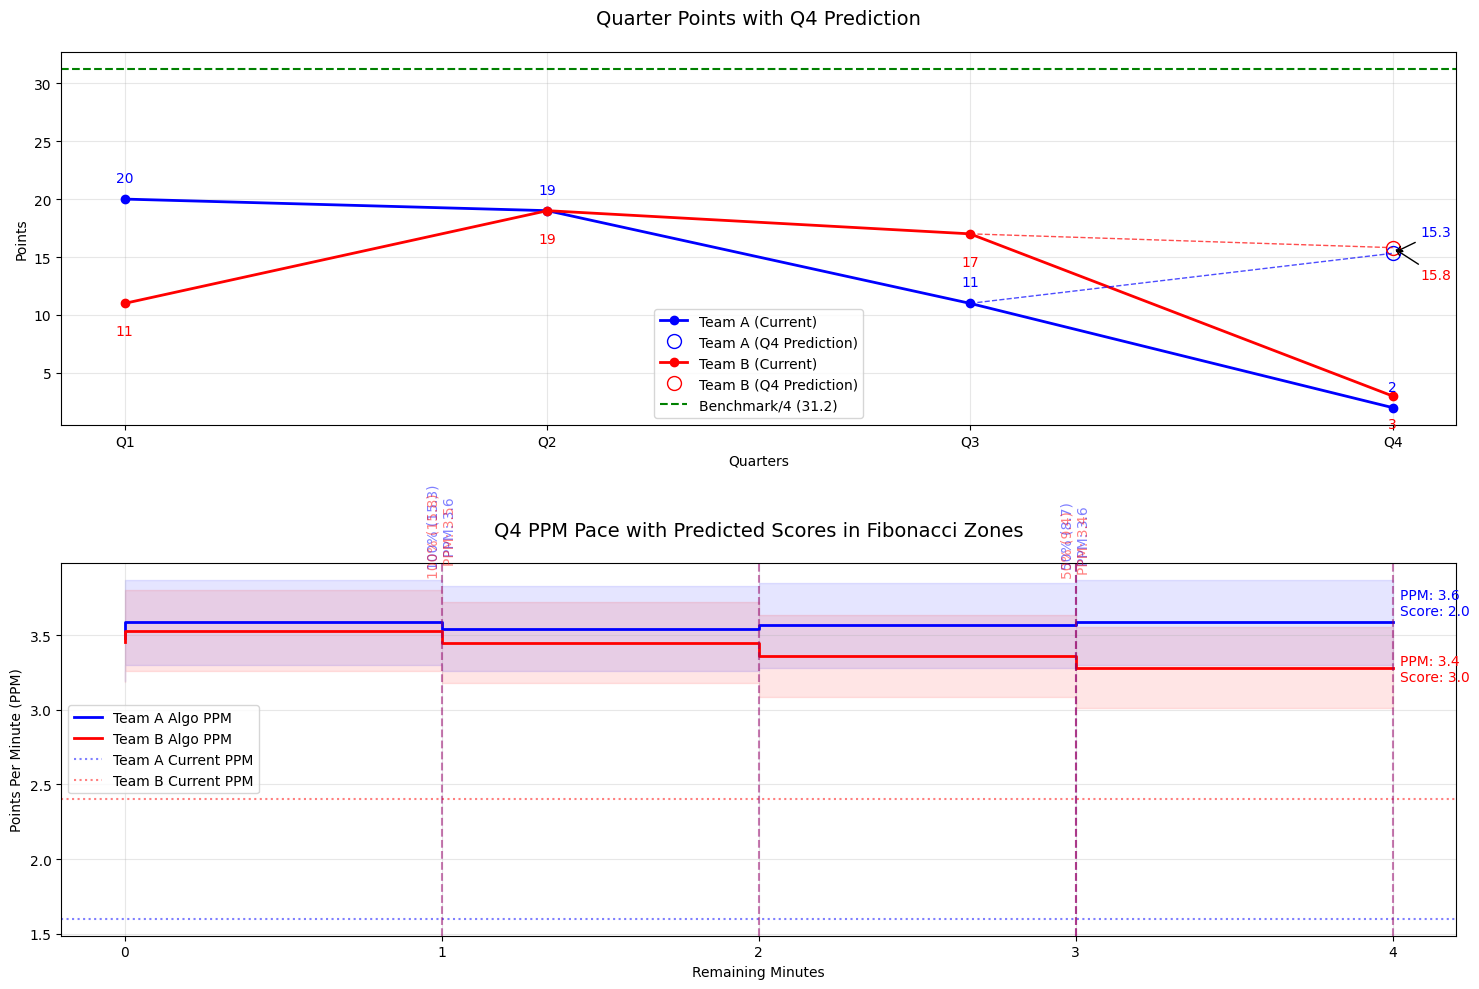

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from typing import List, Dict, Tuple
from tabulate import tabulate

class BasketballPredictor:
    def __init__(self):
        self.transition_matrix = {
            'hot': {'hot': 0.7, 'neutral': 0.2, 'cold': 0.1},
            'neutral': {'hot': 0.2, 'neutral': 0.6, 'cold': 0.2},
            'cold': {'hot': 0.1, 'neutral': 0.2, 'cold': 0.7}
        }

        self.adjustment_factors = {
            'hot': (1.05, 1.15),
            'neutral': (0.95, 1.05),
            'cold': (0.85, 0.95)
        }

        self.indicators = {
            'scoring_rate': 0.4,
            'momentum': 0.4,
            'opponent_performance': 0.2
        }

    def get_inputs(self) -> Tuple:
        try:
            period_length = int(input("Enter the period length (5, 10, or 12 minutes): "))
            if period_length not in [5, 10, 12]:
                raise ValueError("Invalid period length")

            current_quarter = int(input("Enter the current quarter (1, 2, 3, or 4): "))
            if current_quarter not in [1, 2, 3, 4]:
                raise ValueError("Invalid quarter")

            team_a_scores = []
            team_b_scores = []

            for i in range(1, current_quarter):
                team_a_score = int(input(f"Enter Team A's score for Quarter {i}: "))
                team_b_score = int(input(f"Enter Team B's score for Quarter {i}: "))

                if team_a_score < 0 or team_b_score < 0:
                    raise ValueError("Score cannot be negative")

                team_a_scores.append(team_a_score)
                team_b_scores.append(team_b_score)

            remaining_minute = int(input("Enter remaining minutes: "))
            remaining_second = int(input("Enter remaining seconds: "))

            if remaining_minute >= period_length or remaining_second >= 60:
                raise ValueError("Invalid time input")

            remaining_time = remaining_minute + remaining_second / 60

            team_a_current = int(input(f"Enter Team A's score for the current quarter so far: "))
            team_b_current = int(input(f"Enter Team B's score for the current quarter so far: "))

            if team_a_current < 0 or team_b_current < 0:
                raise ValueError("Score cannot be negative")

            team_a_scores.append(team_a_current)
            team_b_scores.append(team_b_current)

            benchmark = int(input("Enter the benchmark value for comparison: "))
            if benchmark < 0:
                raise ValueError("Benchmark cannot be negative")

            return period_length, current_quarter, team_a_scores, team_b_scores, remaining_time, benchmark

        except ValueError as e:
            print(f"\nInput Error: {e}")
            print("Please try again.\n")
            return self.get_inputs()

    def calculate_metrics(self, scores: List[int], opponent_scores: List[int], period_length: int, remaining_time: float) -> Dict:
        metrics = {}
        elapsed_time = (len(scores) - 1) * period_length + (period_length - remaining_time)
        metrics['fullgame_ppm'] = sum(scores) / elapsed_time if elapsed_time > 0 else 0

        current_quarter_time = period_length - remaining_time
        metrics['currentquarter_ppm'] = scores[-1] / current_quarter_time if current_quarter_time > 0 else 0

        if len(scores) > 1:
            previous_scores = scores[:-1]
            previous_time = len(previous_scores) * period_length
            metrics['pastquarters_ppm'] = sum(previous_scores) / previous_time
        else:
            metrics['pastquarters_ppm'] = 0

        metrics['scoring_rate'] = metrics['fullgame_ppm']

        if len(scores) >= 2:
            recent_change = scores[-1] - scores[-2]
            metrics['momentum'] = recent_change / period_length
        else:
            metrics['momentum'] = 0

        metrics['opponent_performance'] = sum(scores) / sum(opponent_scores) if sum(opponent_scores) > 0 else 1

        return metrics

    def determine_state(self, metrics: Dict) -> Tuple[str, float, Dict]:
        state_scores = {'hot': 0, 'neutral': 0, 'cold': 0}
        reasoning = {}

        for indicator, weight in self.indicators.items():
            metric_value = metrics[indicator]
            normalized_value = np.clip(norm.cdf(metric_value, loc=0.5, scale=0.2) * 2 - 1, -1, 1)

            if normalized_value > 0.3:
                state_scores['hot'] += weight
                reasoning[indicator] = 'strong positive'
            elif normalized_value < -0.3:
                state_scores['cold'] += weight
                reasoning[indicator] = 'strong negative'
            else:
                state_scores['neutral'] += weight
                reasoning[indicator] = 'neutral'

        final_state = max(state_scores.items(), key=lambda x: x[1])[0]
        confidence = state_scores[final_state] / sum(self.indicators.values())

        return final_state, confidence, reasoning

    def predict_final_score(self, scores: List[int], opponent_scores: List[int],
                          period_length: int, remaining_time: float) -> Tuple[Dict, Dict]:
        metrics = self.calculate_metrics(scores, opponent_scores, period_length, remaining_time)
        state, confidence, reasoning = self.determine_state(metrics)

        predictions = {
            'fullgame': metrics['fullgame_ppm'] * remaining_time,
            'currentquarter': metrics['currentquarter_ppm'] * remaining_time,
            'pastquarters': metrics['pastquarters_ppm'] * remaining_time,
        }

        min_adj, max_adj = self.adjustment_factors[state]
        adjustment = min_adj + (max_adj - min_adj) * confidence
        predictions['algorithmic'] = predictions['fullgame'] * adjustment

        analysis = {
            'state': state,
            'confidence': confidence,
            'reasoning': reasoning,
            'metrics': metrics,
            'adjustment': adjustment
        }

        return predictions, analysis

    def create_visualizations(self, team_a_data: Dict, team_b_data: Dict,
                            current_quarter: int, benchmark: float, remaining_time: float):
        if remaining_time <= 0:
            print("Cannot create visualizations: remaining time must be positive")
            return

        fig = plt.figure(figsize=(15, 10))

        # First subplot: Quarter-by-quarter points with dotted lines from Q3
        plt.subplot2grid((2, 1), (0, 0))
        quarters = [f'Q{i+1}' for i in range(current_quarter)]
        team_a_quarter_points = team_a_data['scores']
        team_b_quarter_points = team_b_data['scores']
        team_a_q4_prediction = team_a_data['final_scores']['algorithmic'] - sum(team_a_quarter_points[:-1])
        team_b_q4_prediction = team_b_data['final_scores']['algorithmic'] - sum(team_b_quarter_points[:-1])

        plt.plot(quarters, team_a_quarter_points, 'b-o', label='Team A (Current)', linewidth=2)
        plt.plot([quarters[-1]], [team_a_q4_prediction], 'bo', markersize=10,
                label='Team A (Q4 Prediction)', fillstyle='none')
        for i, score in enumerate(team_a_quarter_points):
            plt.annotate(f'{score}', xy=(quarters[i], score), xytext=(0, 10),
                        textcoords='offset points', ha='center', va='bottom', color='blue')
        plt.annotate(f'{team_a_q4_prediction:.1f}', xy=(quarters[-1], team_a_q4_prediction),
                    xytext=(20, 10), textcoords='offset points', ha='left', va='bottom',
                    color='blue', arrowprops=dict(arrowstyle='->'))

        plt.plot(quarters, team_b_quarter_points, 'r-o', label='Team B (Current)', linewidth=2)
        plt.plot([quarters[-1]], [team_b_q4_prediction], 'ro', markersize=10,
                label='Team B (Q4 Prediction)', fillstyle='none')
        for i, score in enumerate(team_b_quarter_points):
            plt.annotate(f'{score}', xy=(quarters[i], score), xytext=(0, -15),
                        textcoords='offset points', ha='center', va='top', color='red')
        plt.annotate(f'{team_b_q4_prediction:.1f}', xy=(quarters[-1], team_b_q4_prediction),
                    xytext=(20, -15), textcoords='offset points', ha='left', va='top',
                    color='red', arrowprops=dict(arrowstyle='->'))

        if current_quarter >= 3:
            plt.plot([quarters[2], quarters[-1]], [team_a_quarter_points[2], team_a_q4_prediction],
                    'b--', linewidth=1, alpha=0.7)
            plt.plot([quarters[2], quarters[-1]], [team_b_quarter_points[2], team_b_q4_prediction],
                    'r--', linewidth=1, alpha=0.7)

        plt.axhline(y=benchmark/4, color='g', linestyle='--', label=f'Benchmark/4 ({benchmark/4:.1f})')
        plt.title('Quarter Points with Q4 Prediction', fontsize=14, pad=20)
        plt.xlabel('Quarters')
        plt.ylabel('Points')
        plt.grid(True, alpha=0.3)
        plt.legend()

        # Second subplot: Q4 PPM Pace with Predicted Scores in Fibonacci Zones
        plt.subplot2grid((2, 1), (1, 0))
        minutes_remaining = int(np.ceil(remaining_time))
        time_points = list(range(minutes_remaining + 1))[::-1]  # Count down from remaining minutes to 0

        team_a_current = team_a_data['scores'][-1]
        team_b_current = team_b_data['scores'][-1]
        team_a_q4_pred = team_a_data['final_scores']['algorithmic'] - sum(team_a_data['scores'][:-1])
        team_b_q4_pred = team_b_data['final_scores']['algorithmic'] - sum(team_b_data['scores'][:-1])

        # Base PPM rates
        team_a_base_ppm = (team_a_q4_pred - team_a_current) / remaining_time if remaining_time > 0 else 0
        team_b_base_ppm = (team_b_q4_pred - team_b_current) / remaining_time if remaining_time > 0 else 0

        # Simulate variable PPM (adjusts to total prediction)
        confidence = team_a_data['analysis']['confidence']
        variation = 0.2 * (1 - confidence)
        team_a_ppm = [team_a_base_ppm * (1 + variation * (np.random.random() - 0.5))
                     for _ in range(len(time_points))]
        team_b_ppm = [team_b_base_ppm * (1 + variation * (np.random.random() - 0.5))
                     for _ in range(len(time_points))]

        # Adjust to match total prediction
        a_total = sum(team_a_ppm) / len(team_a_ppm) * remaining_time
        b_total = sum(team_b_ppm) / len(team_b_ppm) * remaining_time
        team_a_ppm = [ppm * (team_a_q4_pred - team_a_current) / a_total if a_total != 0 else team_a_base_ppm
                     for ppm in team_a_ppm]
        team_b_ppm = [ppm * (team_b_q4_pred - team_b_current) / b_total if b_total != 0 else team_b_base_ppm
                     for ppm in team_b_ppm]

        # Cumulative scores for annotations
        team_a_cumulative = [team_a_current + sum(team_a_ppm[:i+1]) for i in range(len(time_points))]
        team_b_cumulative = [team_b_current + sum(team_b_ppm[:i+1]) for i in range(len(time_points))]

        # Plot PPM pace
        plt.step(time_points, team_a_ppm, 'b-', label='Team A Algo PPM', where='post', linewidth=2)
        plt.step(time_points, team_b_ppm, 'r-', label='Team B Algo PPM', where='post', linewidth=2)

        # Confidence band
        team_a_upper = [ppm + team_a_base_ppm * variation for ppm in team_a_ppm]
        team_a_lower = [ppm - team_a_base_ppm * variation for ppm in team_a_ppm]
        team_b_upper = [ppm + team_b_base_ppm * variation for ppm in team_b_ppm]
        team_b_lower = [ppm - team_b_base_ppm * variation for ppm in team_b_ppm]
        plt.fill_between(time_points, team_a_lower, team_a_upper, color='blue', alpha=0.1, step='post')
        plt.fill_between(time_points, team_b_lower, team_b_upper, color='red', alpha=0.1, step='post')

        # CurrentQuarter PPM reference
        team_a_current_ppm = team_a_data['analysis']['metrics']['currentquarter_ppm']
        team_b_current_ppm = team_b_data['analysis']['metrics']['currentquarter_ppm']
        plt.axhline(y=team_a_current_ppm, color='b', linestyle=':', alpha=0.5, label='Team A Current PPM')
        plt.axhline(y=team_b_current_ppm, color='r', linestyle=':', alpha=0.5, label='Team B Current PPM')

        # Fibonacci scoring zones with predicted scores
        fib_levels = [0.236, 0.382, 0.5, 0.618, 1.0]
        for level in fib_levels:
            a_fib = team_a_current + (team_a_q4_pred - team_a_current) * level
            b_fib = team_b_current + (team_b_q4_pred - team_b_current) * level
            a_time = next((t for t, p in zip(time_points, team_a_cumulative) if p >= a_fib), time_points[-1])
            b_time = next((t for t, p in zip(time_points, team_b_cumulative) if p >= b_fib), time_points[-1])
            a_ppm_at_time = team_a_ppm[time_points.index(a_time)]
            b_ppm_at_time = team_b_ppm[time_points.index(b_time)]
            if team_a_q4_pred != team_a_current:
                plt.axvline(x=a_time, color='b', linestyle='--', alpha=0.3)
                if level in [0.5, 1.0]:
                    plt.text(a_time, max(team_a_ppm) * 1.1, f'{level*100:.0f}% ({a_fib:.1f})\nPPM: {a_ppm_at_time:.1f}',
                            color='blue', alpha=0.5, ha='center', va='bottom', rotation=90)
            if team_b_q4_pred != team_b_current:
                plt.axvline(x=b_time, color='r', linestyle='--', alpha=0.3)
                if level in [0.5, 1.0]:
                    plt.text(b_time, max(team_b_ppm) * 1.1, f'{level*100:.0f}% ({b_fib:.1f})\nPPM: {b_ppm_at_time:.1f}',
                            color='red', alpha=0.5, ha='center', va='bottom', rotation=90)

        # Annotations for base PPM and starting cumulative score
        plt.annotate(f'PPM: {team_a_base_ppm:.1f}\nScore: {team_a_current:.1f}',
                    xy=(time_points[0], team_a_ppm[0]), xytext=(5, 5),
                    textcoords='offset points', color='blue')
        plt.annotate(f'PPM: {team_b_base_ppm:.1f}\nScore: {team_b_current:.1f}',
                    xy=(time_points[0], team_b_ppm[0]), xytext=(5, -10),
                    textcoords='offset points', color='red')

        plt.title(f'Q{current_quarter} PPM Pace with Predicted Scores in Fibonacci Zones', fontsize=14, pad=20)
        plt.xlabel('Remaining Minutes')
        plt.ylabel('Points Per Minute (PPM)')
        plt.xticks(time_points)
        plt.grid(True, alpha=0.3)
        plt.legend()

        plt.tight_layout()
        plt.show()

    def create_results_table(self, team_a_final_scores: Dict, team_b_final_scores: Dict,
                           benchmark: float, team_a_points_needed: Dict,
                           team_b_points_needed: Dict) -> str:
        table_data = []
        headers = ["Method", "Team A", "Team B", "Total", "Benchmark Diff", "Points Needed Q"]

        for method in team_a_final_scores.keys():
            team_a_final = team_a_final_scores[method]
            team_b_final = team_b_final_scores[method]
            total = team_a_final + team_b_final
            benchmark_diff = total - benchmark

            points_needed = f"A: {team_a_points_needed[method]:.1f}, B: {team_b_points_needed[method]:.1f}"

            table_data.append([
                method.title(),
                f"{team_a_final:.2f}",
                f"{team_b_final:.2f}",
                f"{total:.2f}",
                f"{benchmark_diff:.2f}",
                points_needed
            ])

        return tabulate(table_data, headers=headers, tablefmt="grid")

    def create_score_progression_table(self, team_a_scores: List[int], team_b_scores: List[int],
                                     current_quarter: int) -> str:
        table_data = []
        headers = ["Quarter", "Team A Score", "Team B Score", "Quarter Total", "Cumulative Total"]
        cumulative_total = 0

        for i in range(current_quarter):
            quarter = f"Q{i+1}"
            team_a_score = team_a_scores[i]
            team_b_score = team_b_scores[i]
            quarter_total = team_a_score + team_b_score
            cumulative_total += quarter_total

            if i == current_quarter - 1:
                quarter += " (so far)"

            table_data.append([
                quarter,
                f"{team_a_score}",
                f"{team_b_score}",
                f"{quarter_total}",
                f"{cumulative_total}"
            ])

        return tabulate(table_data, headers=headers, tablefmt="grid")

    def create_current_quarter_prediction_table(self, team_a_predictions: Dict, team_b_predictions: Dict,
                                              team_a_current: float, team_b_current: float) -> str:
        table_data = []
        headers = ["Method", "Team A Q Prediction", "Team B Q Prediction", "Quarter Total"]

        for method in team_a_predictions.keys():
            team_a_q_pred = team_a_predictions[method] + team_a_current
            team_b_q_pred = team_b_predictions[method] + team_b_current
            quarter_total = team_a_q_pred + team_b_q_pred

            table_data.append([
                method.title(),
                f"{team_a_q_pred:.2f}",
                f"{team_b_q_pred:.2f}",
                f"{quarter_total:.2f}"
            ])

        return tabulate(table_data, headers=headers, tablefmt="grid")

def main():
    print("\nEnhanced Basketball Score Prediction System")
    print("=" * 50)

    predictor = BasketballPredictor()
    inputs = predictor.get_inputs()
    if inputs is None:
        return

    period_length, current_quarter, team_a_scores, team_b_scores, remaining_time, benchmark = inputs

    team_a_predictions, team_a_analysis = predictor.predict_final_score(
        team_a_scores, team_b_scores, period_length, remaining_time)
    team_b_predictions, team_b_analysis = predictor.predict_final_score(
        team_b_scores, team_a_scores, period_length, remaining_time)

    team_a_final_scores = {
        method: sum(team_a_scores) + pred
        for method, pred in team_a_predictions.items()
    }
    team_b_final_scores = {
        method: sum(team_b_scores) + pred
        for method, pred in team_b_predictions.items()
    }

    team_a_points_needed = {
        method: team_a_final_scores[method] - sum(team_a_scores[:-1])
        for method in team_a_final_scores.keys()
    }
    team_b_points_needed = {
        method: team_b_final_scores[method] - sum(team_b_scores[:-1])
        for method in team_b_final_scores.keys()
    }

    team_a_data = {
        'scores': team_a_scores,
        'final_scores': team_a_final_scores,
        'analysis': team_a_analysis,
        'points_needed_current': team_a_points_needed
    }
    team_b_data = {
        'scores': team_b_scores,
        'final_scores': team_b_final_scores,
        'analysis': team_b_analysis,
        'points_needed_current': team_b_points_needed
    }

    print("\nScore Progression Per Quarter:")
    print(predictor.create_score_progression_table(team_a_scores, team_b_scores, current_quarter))

    print(f"\nPredicted Scores for Q{current_quarter}:")
    print(predictor.create_current_quarter_prediction_table(
        team_a_predictions, team_b_predictions, team_a_scores[-1], team_b_scores[-1]))

    print("\nPredicted Final Scores:")
    print(predictor.create_results_table(team_a_final_scores, team_b_final_scores,
                                       benchmark, team_a_points_needed, team_b_points_needed))

    predictor.create_visualizations(team_a_data, team_b_data, current_quarter, benchmark, remaining_time)

if __name__ == "__main__":
    main()
